<a href="https://colab.research.google.com/github/Murcha1990/Raiffaizen_ML_summer2023/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_12_features/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отбор признаков

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

ds = fetch_california_housing()
X, y = ds.data, ds.target

indexes = np.arange(len(y))
np.random.seed(52342)
np.random.shuffle(indexes)

X = X[indexes, :]
y = y[indexes]

In [5]:
np.corrcoef(X[:,0], y)[0][1]

0.6880752079585478

In [6]:
pearsonr(X[:,0], y)[0]

0.6880752079585477

Отбор по корреляции

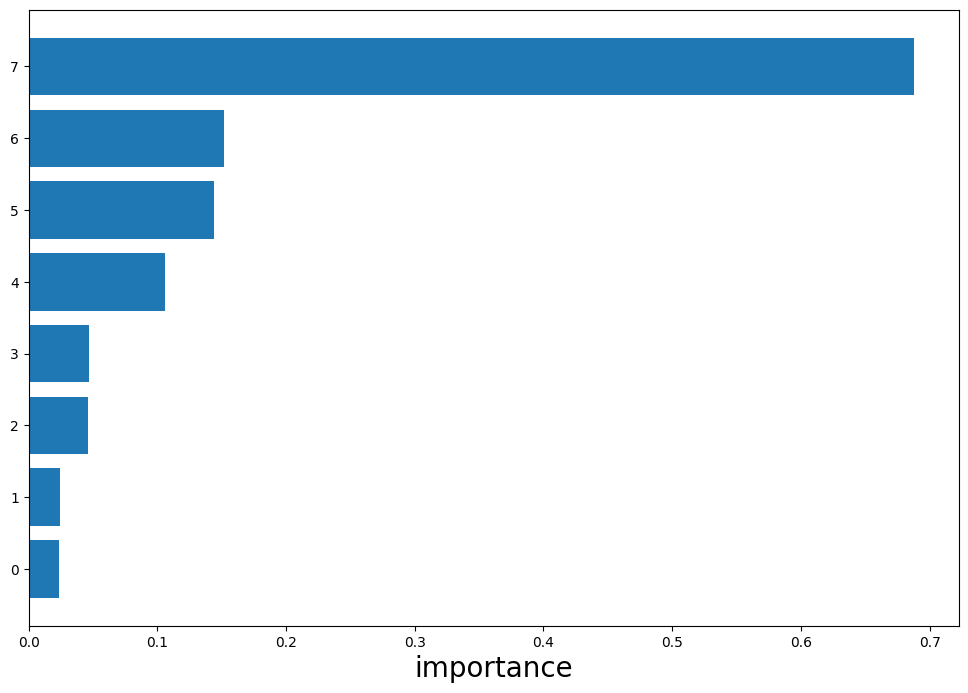

In [8]:
features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)

fig = plt.figure(figsize=(12,8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('importance', fontsize=20)
X = X[:, importances_sort]

In [14]:
from tqdm import tqdm, tqdm_notebook

for i in tqdm_notebook(range(1_000_000_000)):
    pass

<ipython-input-14-a1c40e1c9baa>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1_000_000_000)):


  0%|          | 0/1000000000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

features_counts = np.arange(X.shape[1])

def scores_by_cnt(reg):
    scores = []
    for features_part in tqdm(features_counts):
        X_part = X[:,importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


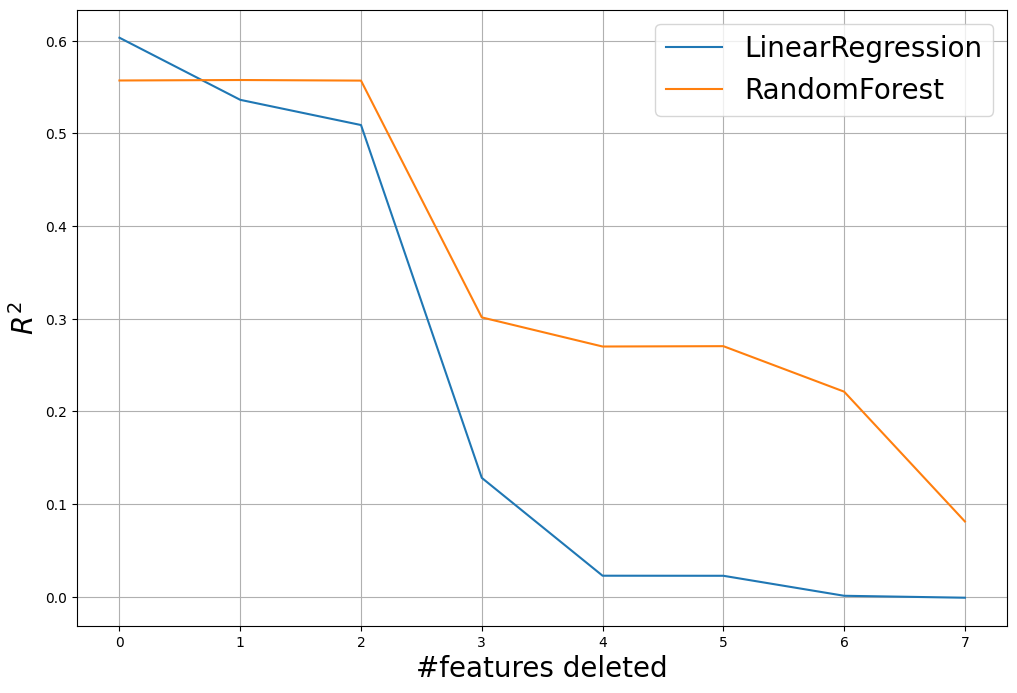

In [15]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Отбор по взаимной информации

In [18]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

select = SelectKBest(score_func=mutual_info_regression, k='all')
z = select.fit_transform(X, y)

print(select.scores_) # важности признаков по mutual_information

importances_sort = np.argsort(select.scores_)

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

[0.073448   0.0211572  0.39960684 0.02386458 0.03300239 0.36710756
 0.1030247  0.38792212]


100%|██████████| 8/8 [01:05<00:00,  8.18s/it]


In [19]:
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
corrs

array([0.02373741, 0.02464968, 0.04596662, 0.04670051, 0.10562341,
       0.14416028, 0.15194829, 0.68807521])

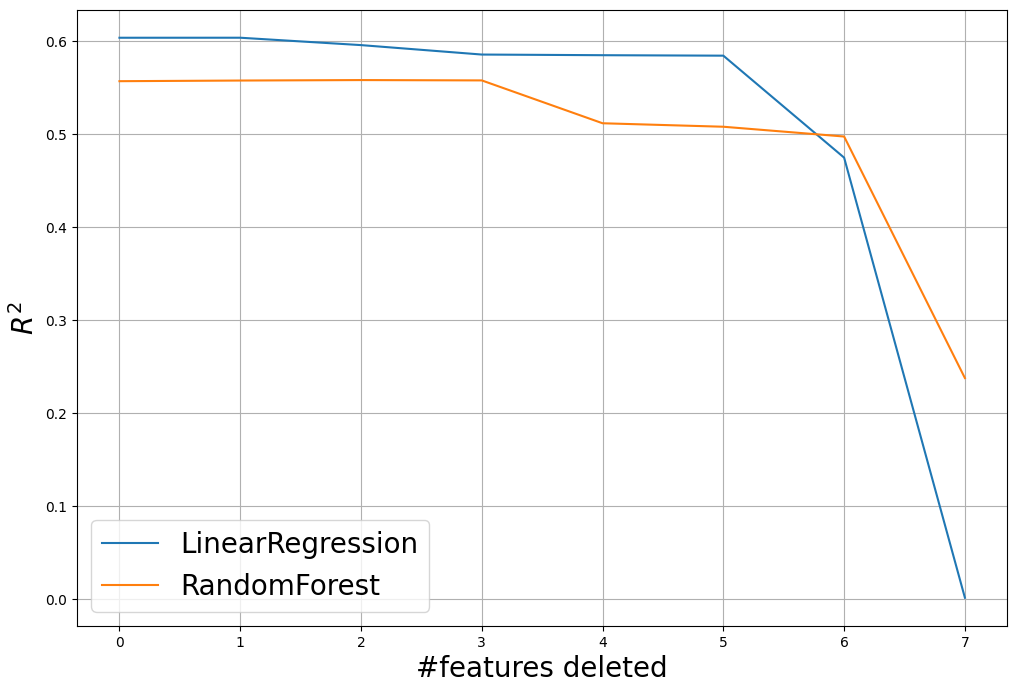

In [17]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Рекурсивный отбор

In [22]:
from sklearn.feature_selection import RFE

def scores_by_rfe(reg):
    scores = []
    for num_features in tqdm(np.arange(8,0,-1)):
        estimator = RandomForestRegressor() # LinearRegression()
        selector = RFE(estimator, n_features_to_select=num_features, step=1)
        selector = selector.fit(X, y)

        X_part = selector.transform(X)
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_rfe(LinearRegression())
rf_scores = scores_by_rfe(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

 12%|█▎        | 1/8 [00:35<04:08, 35.49s/it]


KeyboardInterrupt: ignored

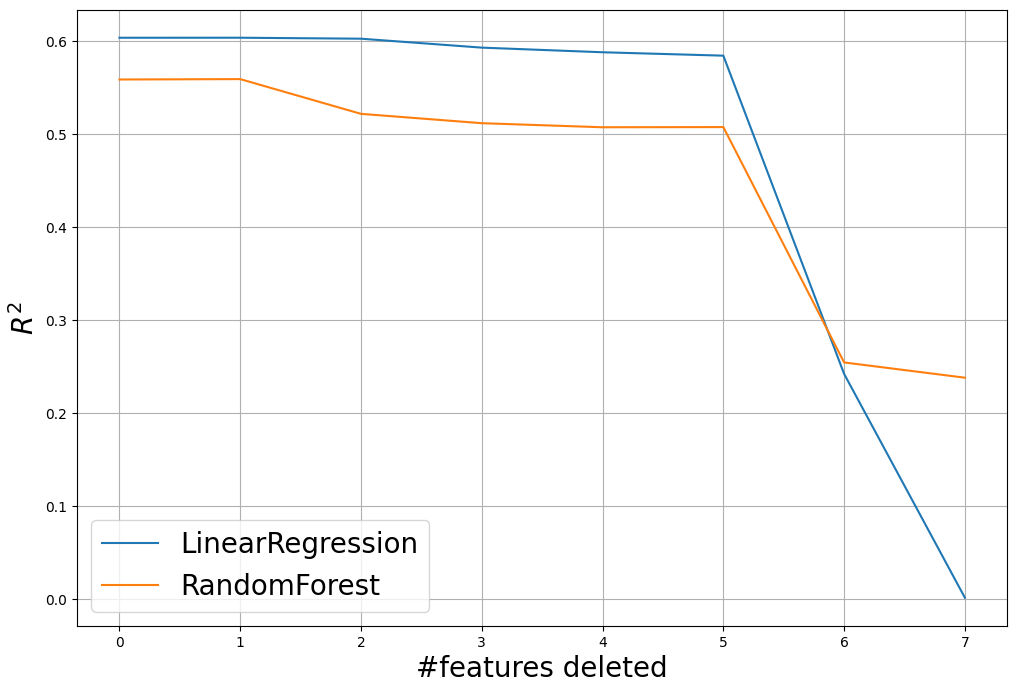

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Отбор по модели

In [23]:
from sklearn.feature_selection import SelectFromModel

estimator = LinearRegression()
selector = SelectFromModel(estimator, threshold=0.1)
selector = selector.fit(X, y)

importances_sort = np.argsort(selector.estimator_.coef_)

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:53<00:00,  6.68s/it]


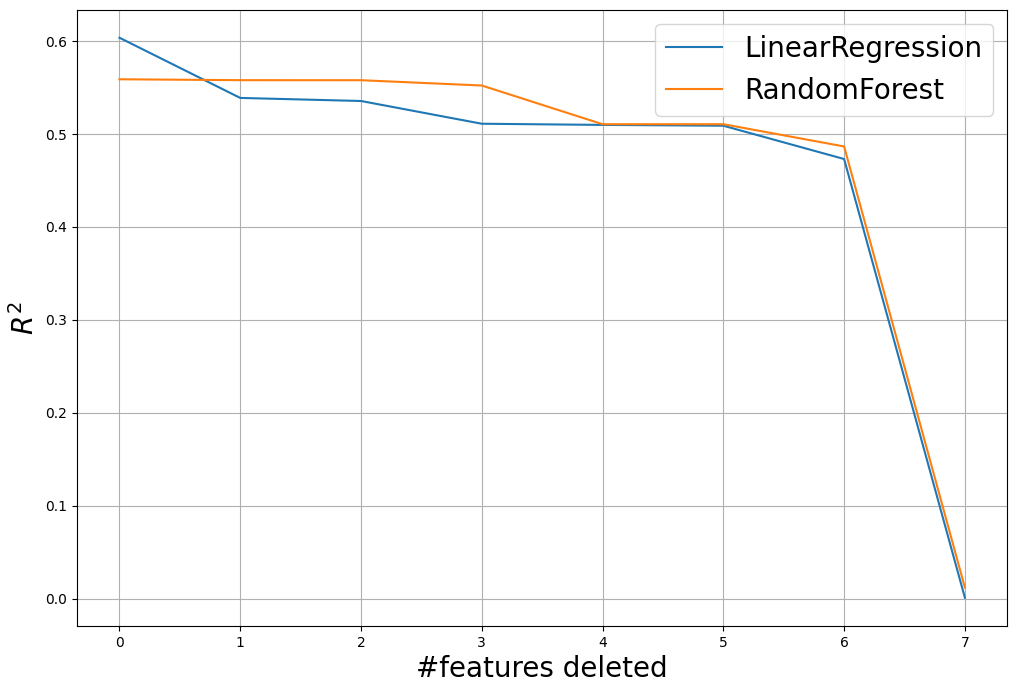

In [25]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

In [28]:
X, y = fetch_california_housing(return_X_y = True, as_frame=True)

In [30]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([                         # fit, transform/predict
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_regression)),
    ('model', RandomForestRegressor())
])

# pipe.fit(Xtrain, ytrain)

# pred = pipe.predict(Xtest)

In [40]:
from sklearn.model_selection import GridSearchCV

params = {'selector__k' : [3, 4, 5, 6],
          'model__n_estimators' : [100, 200, 300]}

gs = GridSearchCV(pipe, params, cv=3, scoring='r2')

gs.fit(Xtrain, ytrain)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x7a34c3018700>)),
                                       ('model', RandomForestRegressor())]),
             param_grid={'selector__k': [3, 4, 5, 6]}, scoring='r2')

In [42]:
gs.best_params_

{'selector__k': 3}

In [43]:
from sklearn.metrics import r2_score

pred = gs.best_estimator_.predict(Xtest)

r2_score(ytest, pred)

0.8246871491202118